#### Sept. 22, 2017

Generate input csv files (from breseq output of annotated.gd) for plotting with the following code snippets from ```lost_polymorphisms.py``` and ```plot_polymorphisms.py```:

In [77]:
import numpy as np
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt

In [3]:
## Two relevant functions from class ComparePolymorphisms, in lost_polymorphisms.py

def get_all_gd(self, evolution_line, input_directory, path_to_ancestor_gd):
    '''
    Input1: name of evolution line
    Input2: directory path to all breseq results
    Input3: path to GenomeDiff file for ancestral (generation 0) population.
    Output: GD files for all generations of the evolution line, concatenated as one data frame.
    '''
    ancestor_df = self.annotated_gd_to_df(path_to_ancestor_gd, 0)
    annotated_gd_files = glob.glob(input_directory + '*' + evolution_line + '*/output/*.gd')
    print(annotated_gd_files)
    all_dataframes = [ancestor_df]
    for genome_diff in annotated_gd_files:
        generation = int(genome_diff[-8:-3].split('-')[1])
        dataframe = self.annotated_gd_to_df(genome_diff, generation)
        all_dataframes.append(dataframe)
    evolution_line_dataframe = pd.concat(all_dataframes, ignore_index=True)
    evolution_line_dataframe.insert(0, 'line', evolution_line)
    return evolution_line_dataframe

def gd_frequencies_to_df(self, df_from_all_gd, save_csv=False, csv_filename='gd_freqs.csv'):
    '''
    Input: output from get_all_gd(), i.e., data frame of combined gd files from one evolution line.
    Output: data frame of all polymorphisms with frequencies, for plotting.
    '''
    df_from_all_gd.insert(2, 'consensus_frequency', 'NaN')
    df_from_all_gd.insert(3, 'polymorphism_frequency', 0.0)
    df_from_all_gd.rename(columns = {0: 'entry_type', 1: 'item_id', 2: 'evidence_id', 3: 'genome_id', 4: 'position', 5: 'mutation_detail'}, inplace=True)
    # entry types obtained from http://barricklab.org/twiki/pub/Lab/ToolsBacterialGenomeResequencing/documentation/gd_format.html
    df_polymorphisms = df_from_all_gd[(df_from_all_gd['entry_type'] == 'INS') | (df_from_all_gd['entry_type'] == 'DEL') | 
            (df_from_all_gd['entry_type'] == 'SNP') | (df_from_all_gd['entry_type'] == 'SUB') | (df_from_all_gd['entry_type'] == 'MOB') | 
            (df_from_all_gd['entry_type'] == 'AMP') | (df_from_all_gd['entry_type'] == 'CON') | (df_from_all_gd['entry_type'] == 'INV')].copy()
    for row in df_polymorphisms.itertuples():
        for col_index in range(6, 51):
            if re.match('frequency', str(df_polymorphisms.loc[row[0], col_index])):
                df_polymorphisms.loc[row[0], 'polymorphism_frequency'] = re.sub('frequency=', '', str(df_polymorphisms.loc[row[0], col_index]))
                if df_polymorphisms.loc[row[0], 'polymorphism_frequency'] == '1':
                    df_polymorphisms.loc[row[0], 'consensus_frequency'] = 1.0
                    evidence_id = df_polymorphisms.loc[row[0], 'evidence_id']
                    evidence_row = df_from_all_gd[df_from_all_gd['item_id'] == evidence_id].index
                    for evidence_col in range(6, 51):
                        if re.match('polymorphism_frequency', str(df_from_all_gd.loc[evidence_row, evidence_col])):
                            df_polymorphisms.loc[row[0], 'polymorphism_frequency'] = re.sub('polymorphism_frequency=', '', str(df_from_all_gd.loc[evidence_row, evidence_col]))
                        break
            break
                
    df_polymorphisms_for_plotting = df_polymorphisms[['line', 'generation', 'entry_type', 'item_id', 'mutation_detail',  
                                                      'genome_id', 'position', 'polymorphism_frequency', 'consensus_frequency']].copy()
    dtype = {'line': str, 'generation': int, 'entry_type': str, 'item_id': str, 'genome_id': str,
             'position': str, 'polymorphism_frequency': float, 'consensus_frequency': float}
    for key, value in dtype.items():
        df_polymorphisms_for_plotting[key] = df_polymorphisms_for_plotting[key].astype(value)
    if save_csv == True:
        df_polymorphisms_for_plotting.to_csv(csv_filename, index=False)
    
    return df_polymorphisms_for_plotting

```
## Script from plot_polymorphisms.py

from lost_polymorphisms import ComparePolymorphisms

input_directory = '~/breseq_results/'
output_directory = '~/plot_polymorphisms/results/'
ancestor_gd_path = input_directory + 'sic_Ancestor_breseq/output/0.gd'
evolution_lines = ['HA3', 'HE3', 'HR2', 'HS3', 'UA3', 'UE3', 'UR1', 'US1']

cp_gd = ComparePolymorphisms()
for line in evolution_lines:
    line_df = cp_gd.get_all_gd(line, input_directory, ancestor_gd_path)
    output_csv = output_directory + line + '_gd_freqs.csv'
    frequencies_df = cp_gd.gd_frequencies_to_df(line_df, save_csv=True, csv_filename=output_csv)
```

##### R/RStudio envy resulted in...

R code to tidy and plot data initially, with much help from [R for Data Science](http://r4ds.had.co.nz/tidy-data.html#missing-values-3). Will rewrite this in Python, once I've learned it!

```
# In plotfreqs.R

library(tidyverse)

get_polymorphisms <- function(filepath) {
  polymorphisms <- read.csv(filepath) %>% 
    unite(polymorphism, position, entry_type, mutation_detail, sep = ' ') %>%
    select(genome_id, polymorphism, generation, polymorphism_frequency) %>% 
    complete(nesting(polymorphism, genome_id), generation, fill = list(polymorphism_frequency = 0))
  return(polymorphisms)
}

plot_polymorphism_frequencies <- function(polymorphism_tibble, output_dir) {
  ggplot(data = polymorphism_tibble, mapping = aes(x = generation, y = polymorphism_frequency)) + 
    geom_line(aes(group = polymorphism)) + 
    facet_wrap(~ genome_id, ncol = 1)
  ggsave(paste(output_dir, 'polymorphism_plot.png', sep = ''), last_plot())
}

# In plot_genotypes.R

source('~/plotfreqs.R')

ue3polymorphisms = get_polymorphisms('~/data/UE3_gd_freqs.csv')
write.csv(ue3polymorphisms, file = '~/ue3polymorphisms.csv', row.names = FALSE, quote = FALSE)
plot_polymorphism_frequencies(ue3polymorphisms, '~/viz/')
```

In [76]:
ue3tidy = pd.read_csv('/Users/ymseah/Repositories/dataviz/data/ue3polymorphisms.csv')
ue3tidy_pivoted = ue3tidy.pivot_table(index=['genome_id','generation'], columns = 'polymorphism', values = 'polymorphism_frequency')
ue3tidy_pivoted

polymorphism          1 DEL 202301  1001862 DEL 82  1010764 DEL 66  \
genome_id generation                                                 
NC_002937 0                    NaN             NaN        0.000000   
          100                  NaN             NaN        0.000000   
          300                  NaN             NaN        0.000000   
          500                  NaN             NaN        0.000000   
          780                  NaN             NaN        0.052055   
NC_005791 0                    NaN        0.000000             NaN   
          100                  NaN        0.000000             NaN   
          300                  NaN        0.052363             NaN   
          500                  NaN        0.000000             NaN   
          780                  NaN        0.000000             NaN   
NC_005863 0                    0.0             NaN             NaN   
          100                  0.0             NaN             NaN   
          300                  0.0             NaN             NaN   
          500                  1.0             NaN             NaN   
          780                  0.0             NaN             NaN   

polymorphism          1031473 DEL 45  1031606 SNP A  1031608 SNP G  \
genome_id generation                                                 
NC_002937 0                      NaN            NaN            NaN   
          100                    NaN            NaN            NaN   
          300                    NaN            NaN            NaN   
          500                    NaN            NaN            NaN   
          780                    NaN            NaN            NaN   
NC_005791 0                 0.000000       0.000000       0.000000   
          100               0.000000       0.000000       0.000000   
          300               0.000000       0.068088       0.074043   
          500               0.054498       0.000000       0.000000   
          780               0.000000       0.000000       0.000000   
NC_005863 0                      NaN            NaN            NaN   
          100                    NaN            NaN            NaN   
          300                    NaN            NaN            NaN   
          500                    NaN            NaN            NaN   
          780                    NaN            NaN            NaN   

polymorphism          1031617 SNP A  1039868 DEL 87  1048916 SNP A  \
genome_id generation                                                 
NC_002937 0                     NaN        0.000000       0.000000   
          100                   NaN        0.000000       0.000000   
          300                   NaN        0.000000       0.085697   
          500                   NaN        0.074834       0.000000   
          780                   NaN        0.000000       0.000000   
NC_005791 0                0.000000             NaN            NaN   
          100              0.000000             NaN            NaN   
          300              0.051211             NaN            NaN   
          500              0.000000             NaN            NaN   
          780              0.000000             NaN            NaN   
NC_005863 0                     NaN             NaN            NaN   
          100                   NaN             NaN            NaN   
          300                   NaN             NaN            NaN   
          500                   NaN             NaN            NaN   
          780                   NaN             NaN            NaN   

polymorphism          1074078 DEL 56      ...       982486 SNP G  \
genome_id generation                      ...                      
NC_002937 0                      NaN      ...                NaN   
          100                    NaN      ...                NaN   
          300                    NaN      ...                NaN   
          500                    NaN      ...                NaN   
          780      

In [85]:
def subset_monotonic(df):
    '''
    Returns 3 lists of column names that have monotonically increasing, decreasing, and non-monotonic values. 
    '''
    mono_inc = []
    mono_dec = []
    mono_oth = []
    for col in df.columns:
        if df[col].is_monotonic_increasing:
            mono_inc.append(col)
        elif df[col].is_monotonic_decreasing:
            mono_dec.append(col)
        else:
            mono_oth.append(col)
    return mono_inc, mono_dec, mono_oth

def plot_summary(df, col1, col2, col3, plottitle):
    fig, axes = plt.subplots(3,1, sharex=True)
    df[col1].plot(ax=axes[0], legend=False, title=plottitle)
    df[col2].plot(ax=axes[1], legend=False)
    df[col3].plot(ax=axes[2], legend=False)

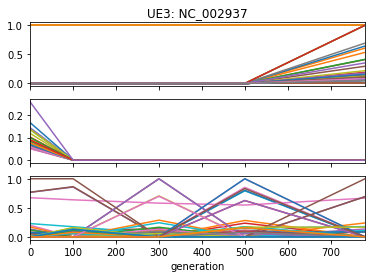

In [86]:
%matplotlib inline

ue3_2937 = ue3tidy_pivoted.loc['NC_002937'].dropna(axis=1, how='all')
inc, dec, oth = subset_monotonic(ue3_2937)
#summary fig
plot_summary(ue3_2937, inc, dec, oth, 'UE3: NC_002937')

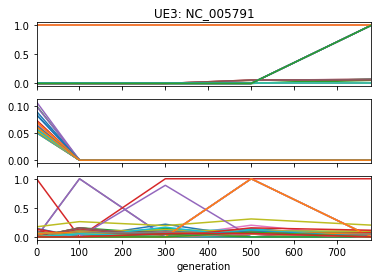

In [87]:
ue3_5791 = ue3tidy_pivoted.loc['NC_005791'].dropna(axis=1, how='all')
inc, dec, oth = subset_monotonic(ue3_5791)
#summary fig
plot_summary(ue3_5791, inc, dec, oth, 'UE3: NC_005791')

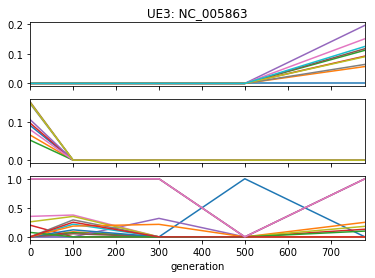

In [88]:
ue3_5863 = ue3tidy_pivoted.loc['NC_005863'].dropna(axis=1, how='all')
inc, dec, oth = subset_monotonic(ue3_5863)
#summary fig
plot_summary(ue3_5863, inc, dec, oth, 'UE3: NC_005863')

Individual plots
```
ue3_5863[inc].plot(title = 'UE3: NC_005863 is_monotonic_increasing', figsize=(20,10)).legend(loc='upper left', ncol=6)
plt.savefig('ue3nc005863_monoInc.png')

ue3_5863[dec].plot(title = 'UE3: NC_005863 is_monotonic_decreasing', figsize=(20,10)).legend(loc='upper right', ncol=6)
plt.savefig('ue3nc005863_monoDec.png')

ue3_5863[oth].plot(title = 'UE3: NC_005863 non-monotonic', figsize=(20,10)).legend(loc='upper right', ncol=6)
plt.savefig('ue3nc005863_monoOth.png')
```